In [2]:
%load_ext autoreload
%autoreload 2

import torch

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.egl.explainer import ExplainerStrategy
from diveslowlearnfast.train.helper import get_test_transform
from diveslowlearnfast.models import SlowFast, load_checkpoint
from diveslowlearnfast.config import Config
from diveslowlearnfast.visualise.gradcam import GradCAM
from diveslowlearnfast.train import helper as train_helper, StatsDB
from diveslowlearnfast.egl import helper as egl_helper

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 2
# cfg.GRADCAM.TARGET_LAYERS = ['head/pathway0_avgpool', 'head/pathway1_avgpool']
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway0_res2']
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model)
model, *_ = load_checkpoint(model, '../misc/checkpoint.pth', optimiser, device)
explainer = ExplainerStrategy.get_explainer(model, cfg=cfg, device=device)

stats_db = StatsDB('./data/stats.db')
difficult_samples = stats_db.get_below_median_samples(
    epoch_start=90,
    run_id='/home/s2871513/Projects/diveslowlearnfast/results/run18',
    split='train'
)

video_ids = list(map(lambda x: x[0], difficult_samples))

train_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg), # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
    video_ids=video_ids
)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [2]:
# xb, yb, _, _, loader_video_ids = next(train_loader_iter)
xb, yb, *_ = next(iter(train_loader))

In [4]:
exp = explainer(xb, yb)

In [15]:
np.median(exp, axis=(1, 2, 3, 4)).shape

(2,)

In [21]:
xb_fast = exp.squeeze(1) # remove dim 1
m = np.median(xb_fast, axis=(1, 2, 3)).reshape((-1, 1, 1, 1)) < xb_fast.numpy()

In [22]:
m.shape

(2, 32, 256, 256)

(-0.5, 255.5, 255.5, -0.5)

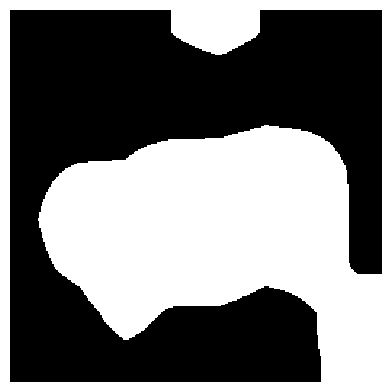

In [26]:
plt.matshow(m[1][1], cmap='gray')
plt.axis('off')

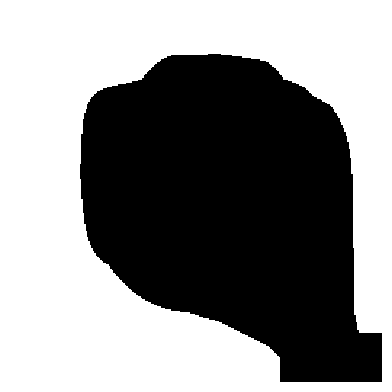

In [23]:
# invert the mask
plt.matshow(~m, cmap='gray')
plt.axis('off')
plt.show()

In [28]:
percentile = 50
features = xb_fast.numpy()
thresh = np.percentile(features, percentile, axis=(1,2,3))
thresh = thresh.reshape((-1,1,1,1))

m = features > thresh

In [29]:
m.shape

(2, 32, 256, 256)

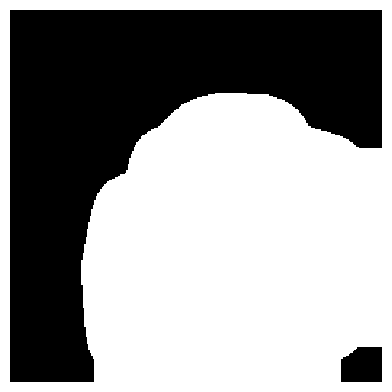

In [30]:
plt.matshow(m[0][0], cmap='gray')
plt.axis('off')
plt.show()

In [32]:
cfg.GRADCAM

## Mask Generation Creation Logic
This section includes logic for when masks should be created. Do we create them only once? Or create them on a interval. If they already exist do we recreate them or do we want to reuse an existing cache.

In [81]:
import os

def masks_exist(cfg: Config):
    slow_masks_dir = os.path.join(cfg.EGL.MASKS_CACHE_DIR, 'slow')
    fast_masks_dir = os.path.join(cfg.EGL.MASKS_CACHE_DIR, 'fast')
    slow_masks_exist = os.path.isdir(slow_masks_dir) and len(os.listdir(slow_masks_dir)) > 0
    fast_masks_exist = os.path.isdir(fast_masks_dir) and len(os.listdir(fast_masks_dir)) > 0
    return slow_masks_exist and fast_masks_exist

def should_generate_masks(cfg: Config, epoch):
    if not cfg.EGL.ENABLED:
        return False

    if not masks_exist(cfg):
        return True

    return cfg.EGL.MASKS_PERIOD != -1 and (epoch % cfg.EGL.MASKS_PERIOD) == 0

epoch = 10

In [86]:
cfg.EGL.MASKS_CACHE_DIR = '.masks'

assert masks_exist(cfg)

cfg.EGL.MASKS_CACHE_DIR = 'data/.masks'

assert masks_exist(cfg) == False


cfg.EGL.ENABLED = False
assert should_generate_masks(cfg, epoch) == False

cfg.EGL.ENABLED = True
cfg.EGL.MASKS_PERIOD = -1
epoch = 0
cfg.EGL.MASKS_CACHE_DIR = '.masks'
assert should_generate_masks(cfg, epoch) == False


cfg.EGL.MASKS_CACHE_DIR = 'data/.masks'
assert should_generate_masks(cfg, epoch)

cfg.EGL.MASKS_PERIOD = 10
epoch = 1
assert should_generate_masks(cfg, epoch) == True

epoch = 0
cfg.EGL.MASKS_CACHE_DIR = '.masks'
assert should_generate_masks(cfg, epoch)

cfg.EGL.MASKS_CACHE_DIR = 'data/.masks'
assert should_generate_masks(cfg, epoch)


epoch = 1
assert should_generate_masks(cfg, epoch)

epoch = 10
assert should_generate_masks(cfg, epoch) == True

## Testing Confounder Mask Creation
Previously we relied on generating the confounder masks and writing them to disk; similar to how other masks are created. But this has the downside of creating a huge cache when we need to consider all examples, this happens specifically when we run the unlearning experiment.

In [48]:
ds = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg), # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
    mask_type='confounder',
    alpha=8
)

In [49]:
x, y, _, _, l, ms, mf = ds[250]

In [50]:
ms.shape, mf.shape, y

(torch.Size([1, 4, 256, 256]), torch.Size([1, 32, 256, 256]), 1)

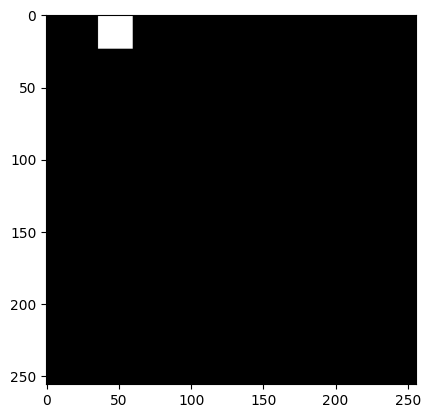

In [33]:
plt.imshow(ms.permute(1, 2, 3, 0)[0].numpy(), cmap='gray')

In [36]:
ds = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg), # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
    alpha=8,
    masks_cache_dir='.masks',
    mask_type='cache'
)

In [37]:
x, y, _, _, l, ms, mf = ds[250]

In [39]:
x.shape, ms.shape, mf.shape, y

(torch.Size([3, 32, 256, 256]), (1, 4, 256, 256), (1, 32, 256, 256), 1)

In [44]:
ds = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg), # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
    mask_type=None,
    alpha=8
)

In [45]:
x, y, _, _, l, ms, mf = ds[250]

In [47]:
x.shape, y, ms, mf, y

(torch.Size([3, 32, 256, 256]), 1, False, False, 1)